In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_info = pd.read_csv("./metadata.csv")
data_info = data_info.fillna(0)
# data_info

In [4]:
# for sample S0000 - first sample
data_info_train = data_info.loc[data_info.split=='train']
data_info_test = data_info.loc[data_info.split=='val']


In [5]:
# print("TRAIN", data_info_train.describe(), "\n\nTEST",data_info_test.describe())

# Train Data (labeled)
Train data 809 rows  \
We have to split this into two parts (train and valid) 
# Test  Data (predict)
Test  data 312 rows  -- we have to predict this data 

In [6]:
data_label = pd.read_csv('./train_labels.csv')

This is the break down of label dataset

In [7]:
print("output".ljust(50) , " 0".ljust(5), "1".ljust(10))
print()
for cols in data_label.columns[1:]:
    print(str(cols).ljust(50) , np.array(data_label[cols].value_counts()))

output                                              0    1         

aromatic                                           [730  79]
hydrocarbon                                        [544 265]
carboxylic_acid                                    [694 115]
nitrogen_bearing_compound                          [713  96]
chlorine_bearing_compound                          [791  18]
sulfur_bearing_compound                            [778  31]
alcohol                                            [783  26]
other_oxygen_bearing_compound                      [788  21]
mineral                                            [692 117]


In [8]:
data_label.describe()

,aromatic,hydrocarbon,carboxylic_acid,nitrogen_bearing_compound,chlorine_bearing_compound,sulfur_bearing_compound,alcohol,other_oxygen_bearing_compound,mineral
count,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000,809.000000
mean,0.097651,0.327565,0.142151,0.118665,0.022250,0.038319,0.032138,0.025958,0.144623
std,0.297026,0.469616,0.349421,0.323594,0.147586,0.192084,0.176477,0.159108,0.351938
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# time series analysis

In [9]:
# plt.plot([1, 2, 3, 4], [1, 4, 9, 16])
# ysdf = 0
cols = list(data_info.columns)
cols.remove('features_md5_hash')
cols
label_names = ['sample_id', 'aromatic', 'hydrocarbon', 'carboxylic_acid',
       'nitrogen_bearing_compound', 'chlorine_bearing_compound',
       'sulfur_bearing_compound', 'alcohol', 'other_oxygen_bearing_compound',
       'mineral']

In [21]:
data_label

,sample_id,aromatic,hydrocarbon,carboxylic_acid,nitrogen_bearing_compound,chlorine_bearing_compound,sulfur_bearing_compound,alcohol,other_oxygen_bearing_compound,mineral
0,S0000,0,0,0,0,0,0,0,0,1
1,S0001,0,0,0,0,0,0,0,0,0
2,S0002,0,0,1,1,0,0,0,0,1
3,S0003,0,1,0,0,0,0,0,0,0
4,S0004,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
804,S0804,0,1,0,0,0,0,0,0,0
805,S0805,0,1,0,0,0,0,0,0,0
806,S0806,0,0,0,0,0,0,0,0,1
807,S0807,0,1,0,0,0,0,0,0,0


In [30]:
import math # takes around 5 mins for loading 
m = 809
label = 0
# plt.figure()


sel_label = "aromatic"
print(sel_label)
labs = []
lens = []
for i in range(0,m,5):
    sid , sp , der ,path = data_info[cols].iloc[i]
    label = data_label.iloc[i][sel_label]
    data = pd.read_csv(path)
    labs.append(label)
    lens.append(len(data))
    

    # break

aromatic


<Axes: >

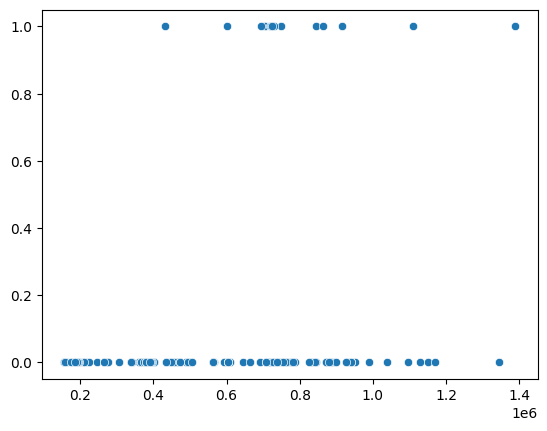

In [32]:
sns.scatterplot(x= lens , y = labs)

In [34]:
# labs